In [1]:
import pandas as pd
import numpy as np

from tqdm import tqdm
from sklearn import preprocessing
from scipy import stats
from itertools import combinations

from news_vec.utils import read_json_gz_lines

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import altair as alt
import seaborn as sns

mpl.style.use('seaborn-muted')
sns.set(style="whitegrid")

%matplotlib inline

In [25]:
df = pd.DataFrame(list(tqdm(read_json_gz_lines('../../data/clf-ab-rows.json/'))))

1278944it [00:24, 52025.17it/s]


In [28]:
d1s, d2s = zip(*df[['d1', 'd2']].apply(lambda x: sorted(x), 1))

In [29]:
df.drop(['d1', 'd2'], 1)
df['d1'] = d1s
df['d2'] = d2s

In [30]:
df['p_false'] = 1 - df.p_true

In [31]:
ARTICLE_DOMAIN_COUNTS = {}

for row in tqdm(read_json_gz_lines('../../data/article-domain-counts.json')):
    ARTICLE_DOMAIN_COUNTS[row['article_id'], row['domain']] = row['count']

17482106it [00:57, 303326.98it/s]


In [32]:
domains = list(df.domain.unique())
dtoi = {d: i for i, d in enumerate(domains)}

In [33]:
def article_domain_dist(aid):
    counts = [ARTICLE_DOMAIN_COUNTS.get((aid, d), 0) for d in domains]
    return np.array(counts) / sum(counts)

In [43]:
def sl_audience_corr(d1, d2, plot=False, height=5):
    
    d1s, d2s = sorted([d1, d2])
    
    pdf = df[(df.d1==d1s)&(df.d2==d2s)&(df.domain==d1)].copy()
    pdf['d2_actor_pct'] = [article_domain_dist(aid)[dtoi[d2]] for aid in pdf.article_id]

    if plot:

        sns.jointplot(
            y='d2_actor_pct',
            x='p_false',
            data=pdf[preprocessing.scale(pdf.d2_actor_pct) < 3],
            kind='reg',
            scatter_kws=dict(s=1),
            height=height,
        )
        
        plt.show()
    
    return stats.kendalltau(pdf.p_false, pdf.d2_actor_pct), pdf

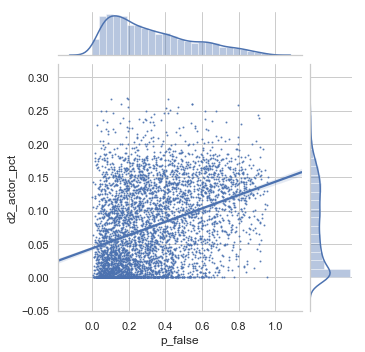

In [44]:
_ = sl_audience_corr('huffingtonpost.com', 'thehill.com', True)

In [38]:
pairs = list(combinations(domains, 2))

In [39]:
rows = []
for d1, d2 in tqdm(pairs):

    kt, pdf = sl_audience_corr(d1, d2)
    rows.append((d1, d2, kt.correlation, kt.pvalue, pdf.d2_actor_pct.mean()))
    
    kt, pdf = sl_audience_corr(d2, d1)
    rows.append((d2, d1, kt.correlation, kt.pvalue, pdf.d2_actor_pct.mean()))

100%|██████████| 136/136 [03:06<00:00,  1.39s/it]


In [41]:
corr_df = pd.DataFrame(rows, columns=('d1', 'd2', 'corr', 'p', 'mean_d2_pct'))
corr_df['label'] = corr_df.apply(lambda r: f'{r.d1} -> {r.d2}', 1)

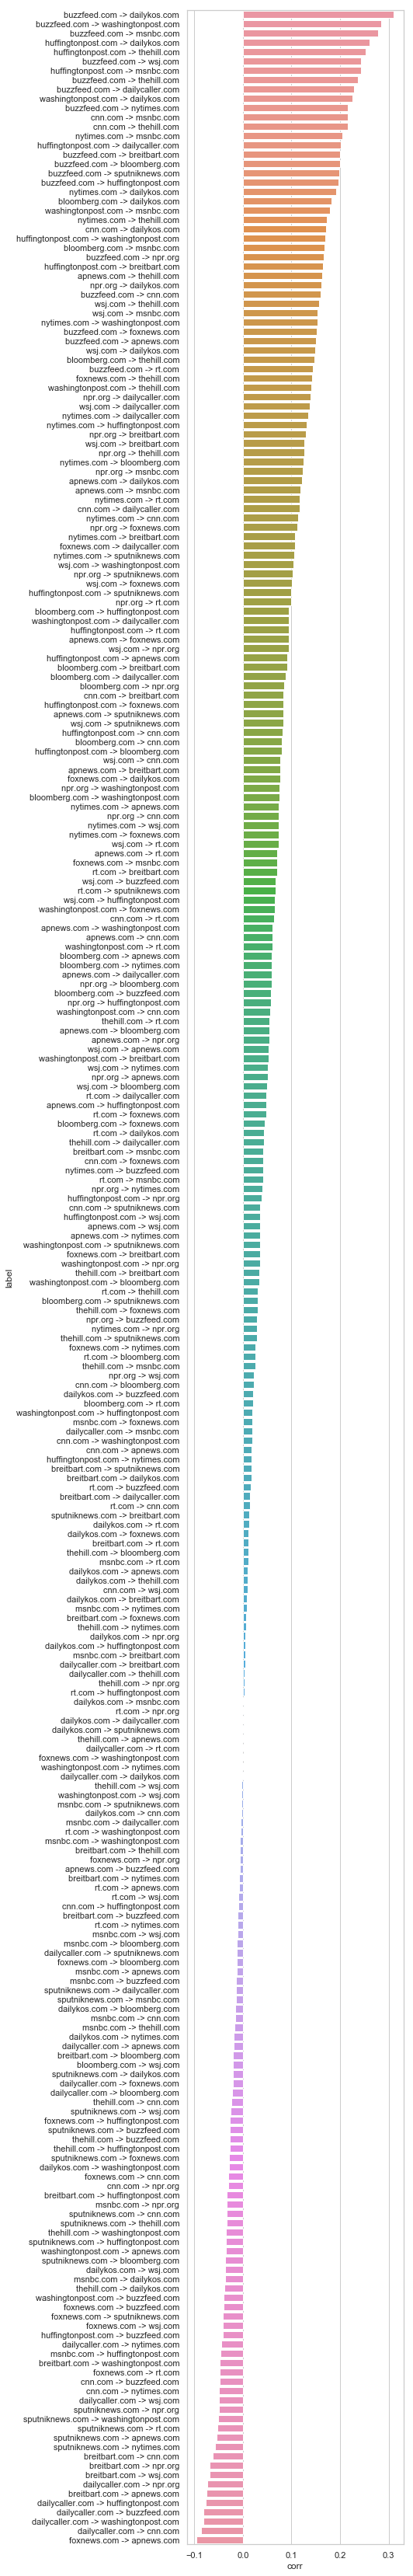

In [42]:
plt.figure(figsize=(5,60))
sns.barplot(x='corr', y='label', data=corr_df.sort_values('corr', ascending=False))

buzzfeed.com dailykos.com


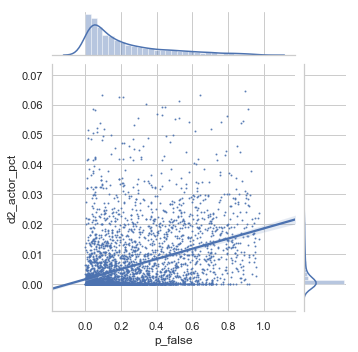

buzzfeed.com washingtonpost.com


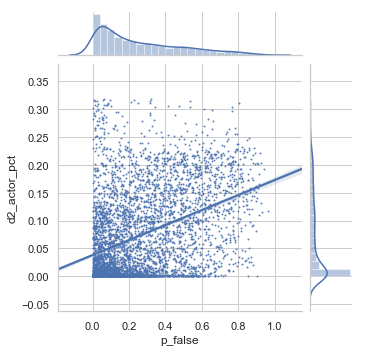

buzzfeed.com msnbc.com


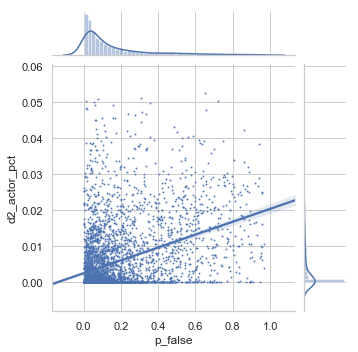

huffingtonpost.com dailykos.com


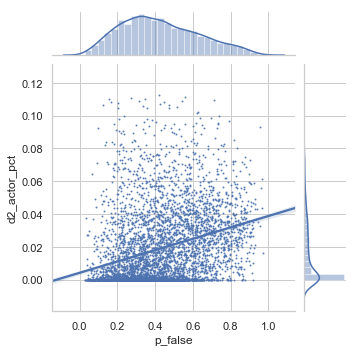

huffingtonpost.com thehill.com


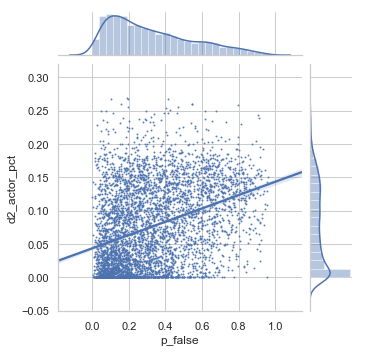

buzzfeed.com wsj.com


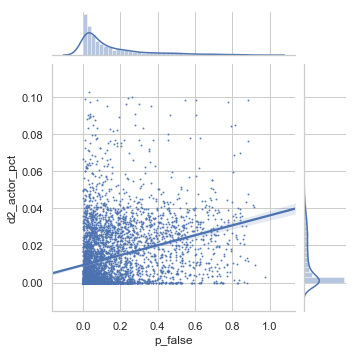

huffingtonpost.com msnbc.com


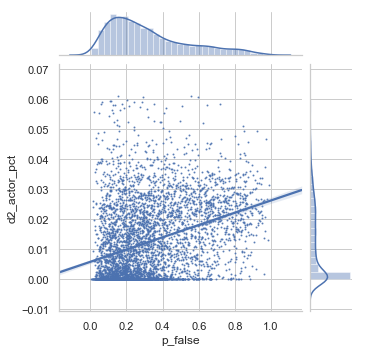

buzzfeed.com thehill.com


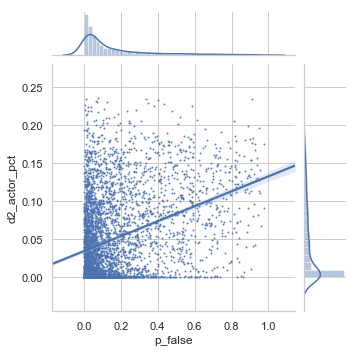

buzzfeed.com dailycaller.com


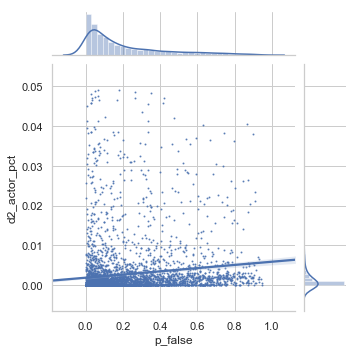

washingtonpost.com dailykos.com


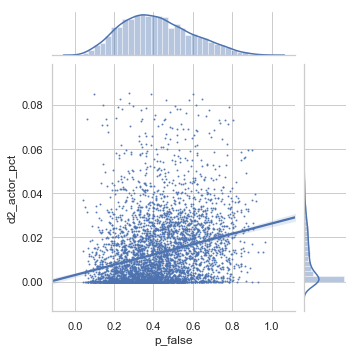

In [45]:
for r in corr_df.sort_values('corr', ascending=False).head(10).itertuples():
    print(r.d1, r.d2)
    sl_audience_corr(r.d1, r.d2, True)

foxnews.com apnews.com


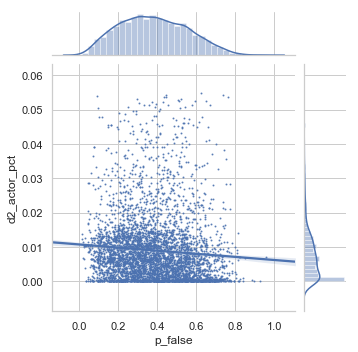

dailycaller.com cnn.com


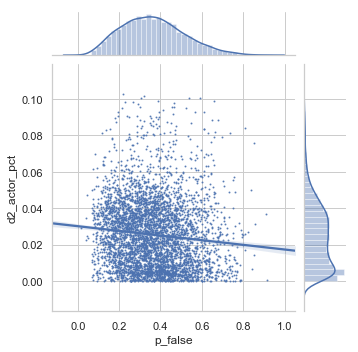

dailycaller.com washingtonpost.com


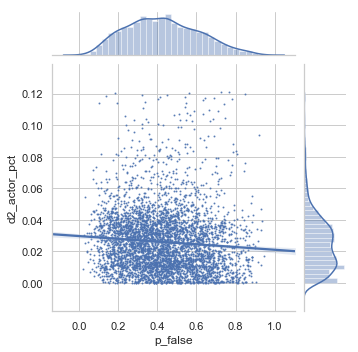

dailycaller.com buzzfeed.com


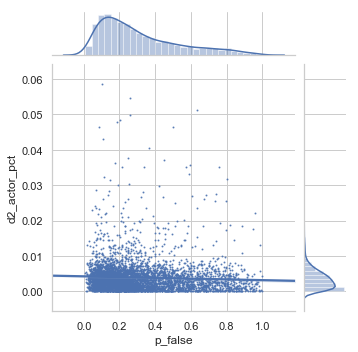

dailycaller.com huffingtonpost.com


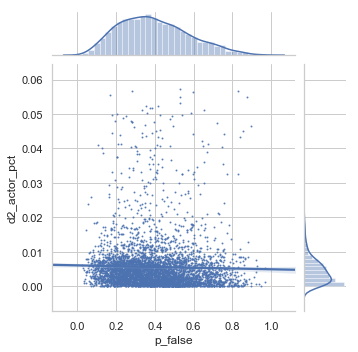

breitbart.com apnews.com


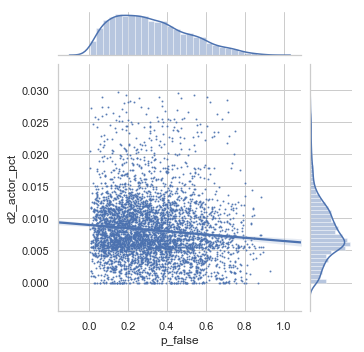

dailycaller.com npr.org


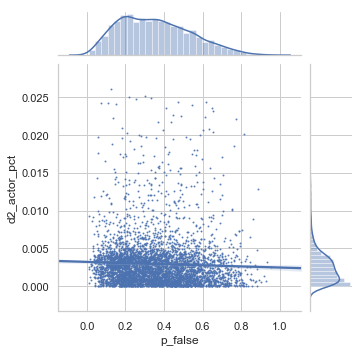

breitbart.com wsj.com


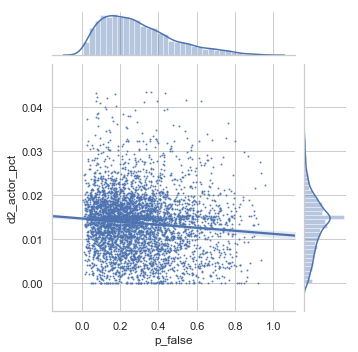

breitbart.com npr.org


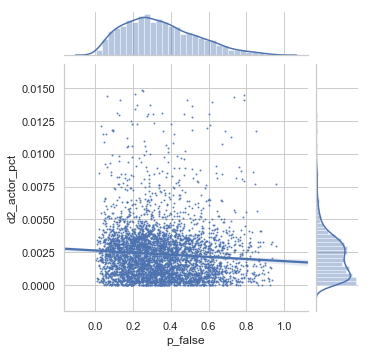

breitbart.com cnn.com


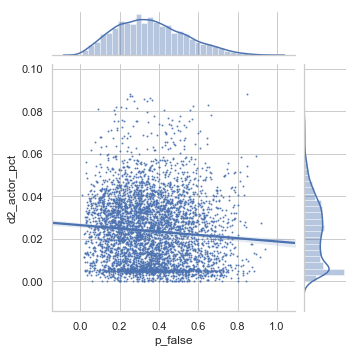

In [46]:
for r in corr_df.sort_values('corr', ascending=True).head(10).itertuples():
    print(r.d1, r.d2)
    sl_audience_corr(r.d1, r.d2, True)

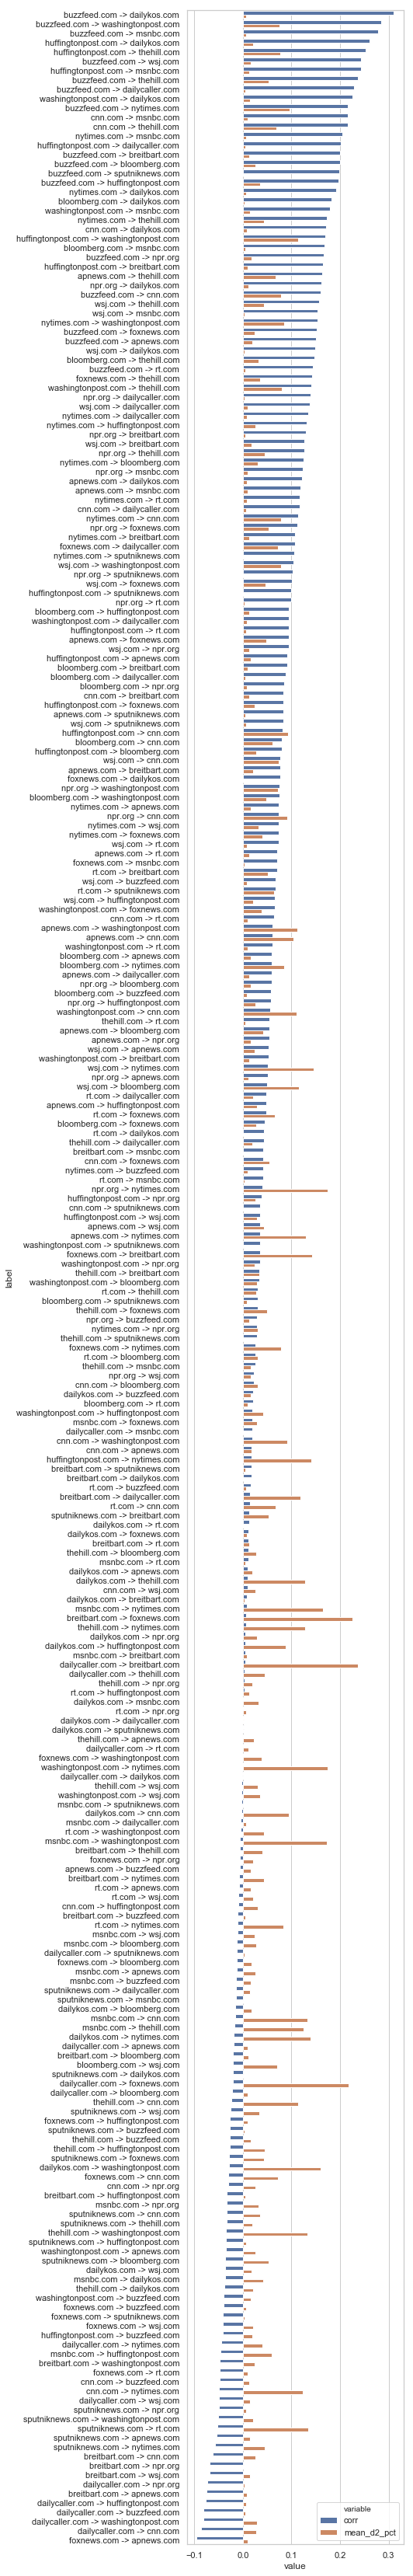

In [47]:
mdf = corr_df.melt(['d1', 'd2', 'label'], ['corr', 'mean_d2_pct'])
order = mdf[mdf.variable=='corr'].sort_values('value', ascending=False).label
plt.figure(figsize=(5,60))
sns.barplot(x='value', y='label', data=mdf, hue='variable', order=order)

In [48]:
stats.kendalltau(corr_df['corr'], corr_df.mean_d2_pct)

KendalltauResult(correlation=-0.048675927935749944, pvalue=0.23151147125905813)